# Spaceship Titanic
### EARIN project

Mariya Zacharneva, Ruslan Melnyk

## Load data



In [1]:
import pandas as pd
import numpy as np
import math
import gdown
import joblib
from google.colab import drive
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import learning_curve

Load the Dataset

In [2]:
gdown.download("https://drive.google.com/uc?export=download&id=1lGlL46nwEiAod5ts_oEiKsI441Q2oFDy", 'train.csv', quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1H_DNImwWzLK5XCmLclst2MKLzBERAHbM", 'test.csv', quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1H_DNImwWzLK5XCmLclst2MKLzBERAHbM", 'sample_submission.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1lGlL46nwEiAod5ts_oEiKsI441Q2oFDy
To: /content/train.csv
100%|██████████| 805k/805k [00:00<00:00, 59.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1H_DNImwWzLK5XCmLclst2MKLzBERAHbM
To: /content/test.csv
100%|██████████| 372k/372k [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1H_DNImwWzLK5XCmLclst2MKLzBERAHbM
To: /content/sample_submission.csv
100%|██████████| 372k/372k [00:00<00:00, 13.7MB/s]


'sample_submission.csv'

In [3]:
train_dataset = pd.read_csv("train.csv")
print("Train dataset shape is {}".format(train_dataset.shape))

Train dataset shape is (8693, 14)


The data is composed of 14 columns and 8693 entries. We can see all 14 dimensions of our dataset by printing out the first 5 entries using the following code:

## Data Analysis

### Basic exploration

First step is to see example values from the dataset, just to get an idea about what data are we dealing with.

Here we can see the structure of the data: each passenger has information about their home planet, location on the space ship, what they have been doing during the flight and so on. The most important column is the last one - who was transported to an alternate dimension. This column we will try to predict.

In [4]:
train_dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Not all the data can be meaningfull: often datasets contains empty entries, which can disturb the learning of the model. Let's explore how many null values do we have.*italicized text*

In [6]:
train_dataset.isnull().sum().sort_values(ascending=False)

,0
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Name,200
Cabin,199
VRDeck,188
Spa,183
FoodCourt,183
Destination,182


-> Most features have around 200 missing values out of 8693 (2%).

Another function we can use is "describe" - it generates descriptive statistics for numeric values.

In [7]:
train_dataset.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


## Prepare Data

This dataset contains a mix of numeric, categorical and missing features.

Before analysing data further, we should preprocess it for convenience, depending on the data type.


In [8]:
# Columns by type
cat_cols = ['HomePlanet', 'CabinDeck', 'Destination', 'CabinSide']
bool_cols = ['CryoSleep', 'VIP']
logs_cols = ['ShoppingMall', 'VRDeck', 'FoodCourt', 'Spa', 'RoomService']
num_cols = ['CabinNumber', 'Age', 'PassengerGroup'] + [col for col in logs_cols]
label_col = 'Transported'

- We break some of of the features into multiple new columns. In particular, `PassengerId` consists of passenger group and passenger number and `Cabin` consists of cabin deck, cabin number and cabin side - all of these indicate the location of the passenger

In [9]:
def extract_features(df):
    df[["PassengerGroup", "PassengerNumber"]] = df["PassengerId"].str.split("_", expand=True)
    df["PassengerGroup"] = pd.to_numeric(df["PassengerGroup"])

    df[["CabinDeck", "CabinNumber", "CabinSide"]] = df["Cabin"].str.split("/", expand=True)
    df["CabinNumber"] = pd.to_numeric(df["CabinNumber"])

- Some of the columns are clearly irrelevant, such as name or passenger number, since these are too individual. We can also drop previously processed columns

In [10]:
def drop_irrelevant_columns(df):
    df.drop(['PassengerId', 'Cabin', 'Name', 'PassengerNumber'], axis=1, inplace=True)

- Now we have to eliminate NaN values. For numerical columns, we decided to use median value, and for other types of data we are just using the most frequent value as the most probable.

In [11]:
def impute_missing_entries(df):
    num_imputer = SimpleImputer(strategy='median')
    bool_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    df[bool_cols] = bool_imputer.fit_transform(df[bool_cols])
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

### Apply data transformation

In [12]:
extract_features(train_dataset)
drop_irrelevant_columns(train_dataset)
impute_missing_entries(train_dataset)

In [13]:
train_dataset.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinNumber,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,F,1.0,S


## Data visualisation

In [14]:
def plot_histograms(df, cols, title="", cols_per_row=3, show_target_means=False, nbinsx=50):
    n = len(cols)
    rows = math.ceil(n / cols_per_row)

    fig = make_subplots(rows=rows, cols=cols_per_row, subplot_titles=cols)

    for i, col in enumerate(cols):
        row = i // cols_per_row + 1
        col_pos = i % cols_per_row + 1

        if show_target_means:
            temp = df[[col, label_col]].copy()
            temp[col] = temp[col].fillna('[null]')
            grouped = temp.groupby(col, observed=True)[label_col].mean().reset_index()

            trace = go.Bar(
              x=grouped[col].astype(str),
              y=grouped[label_col],
              name=col
          )
        else:
            trace = go.Histogram(x=df[col].fillna('[null]'), nbinsx=nbinsx, name=col)

        fig.add_trace(trace, row=row, col=col_pos)

    fig.update_layout(showlegend=False, title_text=title)
    fig.show()

The most important field for us is `Transported`, so let's explore it first. As we can see, about half of the passengers were transported.

In [15]:
plot_histograms(train_dataset, [label_col], "", 1)

## Numerical features

In [16]:
plot_histograms(train_dataset, num_cols, "Numeric Features Distribution")

- All numeric features except for `Age`, `PassengerGroup`, and `CabinNumber` are extremely skewed.
- Passenger group numbers are well distributed.
- Cabin numbers are concentrated at the lower end of range.

Ideas for transformations:
- `Age`, `PassengerGroup` and `CabinNumber` can be discretized.
- Applying a **log transformation** to amenities can help.

In [17]:
fig = make_subplots(rows=3, cols=3, subplot_titles=num_cols)

for i, col in enumerate(num_cols):
    binned = pd.cut(train_dataset[col], bins=50)

    grouped = train_dataset.groupby(binned, observed=True)['Transported'].agg(['mean', 'count']).reset_index()

    trace = go.Scatter(
        x=grouped[col].astype(str),
        y=grouped['mean'],
        mode='lines+markers',
        name=col
    )

    fig.add_trace(trace, row=i // 3 + 1, col=i % 3 + 1)

fig.update_xaxes(showticklabels=False)
fig.update_layout(height=800, title_text="Transported Probability vs Numeric Features", showlegend=False)
fig.show()

- Kids have a higher probability of being transported
- Passengers with group number between 20 and 40, as well as those from cabin numbers between 850 and 1100 are more likely to be transported
- It seems like those who spent between 5100 to 9300 on shopping and those who spent more than 17000 on food are more likely to be tranported
- It is hard to read tendencies from the amenities since the distributions are skewed

## Boolean features

In [18]:
plot_histograms(train_dataset, bool_cols, "Boolean Features Distribution", 2)

<ipython-input-14-97661568529f>:22: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



- There are very few VIPs.
- 1/3 of the passenges where in crio sleep.

In [19]:
plot_histograms(train_dataset, bool_cols, "Transported Probability vs Boolean Features", 2, True)

<ipython-input-14-97661568529f>:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-14-97661568529f>:13: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



- For VIP correlation is not too big
- Those who were in cryo sleep are much more likely to be tranported

## Categorical features

In [20]:
fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}]*4],
                    subplot_titles=cat_cols)

for i, col in enumerate(cat_cols):
    value_counts = train_dataset[col].fillna('[null]').value_counts()
    fig.add_trace(
        go.Pie(labels=value_counts.index, values=value_counts.values, name=col),
        row=1,
        col=i + 1
    )

fig.update_layout(title_text="Categorical Features Distribution")
fig.show()

- Last cabin decks are more populated, cabin T is very rare
- 50% of people are coming from Earth, 21% from Mars, 25% from Europa
- Most people are traveling to TRAPPIST

In [21]:
plot_histograms(train_dataset, cat_cols, "Transported Probability vs Categorical Features", 4, True)

- Passengers from Europa are more likely to be transported
- Those from cabin decks B and C are more likely to be transported
- Those traveling to 55 Cancri are more likely to be transported
- It seems like those from cabin deck T are less likely to be transported, but it's sample is too low (5 people only)
- Those from cabin side S are more likely to be transported

## Correlations

For exploring correlations between different attributes, we have to encode all categorical and boolean values to numerical ones. Categorical values are mapped to different integers; bool values are mapped to 0 or 1 respectfully.

Additionally, logarithmic transformation was applied to some of the columns, which values are distributed over a wide range. This will compress large values and expand small values, effectively reducing skewness in data. This transformation can make correlations more visible.

In [22]:
def convert_booleans(df):
    for col in bool_cols:
        df[col] = df[col].astype(float) # preserves NaNs

def encode_categoricals(df):
    mappings = {}
    for col in cat_cols:
        df[col] = df[col].astype('category')
        mappings[col] = dict(enumerate(df[col].cat.categories))
        df[col] = df[col].cat.codes.replace(-1, np.nan) # preserve NaNs
    return mappings

def apply_log_transform(df):
    for col in logs_cols:
        df[col] = np.log1p(df[col]) # preserves NaNs

In [23]:
convert_booleans(train_dataset)
mappings = encode_categoricals(train_dataset)
apply_log_transform(train_dataset)

In [24]:
train_dataset.corr().style.background_gradient(cmap='RdBu', vmin=-0.6, vmax=0.6)\
  .set_sticky(axis=0)\
  .format(precision=3)\
  .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '9pt'), ('width', '20px'), ('height', '20px')]},
        {'selector': 'td', 'props': [('font-size', '9pt'), ('width', '20px'), ('height', '20px')]}
    ])

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinDeck,CabinNumber,CabinSide
HomePlanet,1.000,0.084,0.035,0.134,0.124,0.175,-0.042,0.093,-0.005,-0.074,0.115,-0.006,-0.409,-0.199,0.001
CryoSleep,0.084,1.000,-0.096,-0.071,-0.078,-0.468,-0.476,-0.457,-0.487,-0.469,0.460,-0.007,0.019,-0.038,0.024
Destination,0.035,-0.096,1.000,-0.007,-0.045,0.090,-0.054,0.086,-0.005,-0.035,-0.108,-0.003,0.184,0.103,-0.013
Age,0.134,-0.071,-0.007,1.000,0.092,0.118,0.196,0.095,0.182,0.164,-0.074,-0.009,-0.242,-0.129,0.012
VIP,0.124,-0.078,-0.045,0.092,1.000,0.050,0.124,0.031,0.089,0.103,-0.037,0.014,-0.178,-0.097,-0.009
RoomService,0.175,-0.468,0.090,0.118,0.050,1.000,0.090,0.361,0.147,0.094,-0.356,0.003,0.049,0.059,-0.022
FoodCourt,-0.042,-0.476,-0.054,0.196,0.124,0.090,1.000,0.101,0.423,0.458,-0.135,0.004,-0.300,-0.148,0.011
ShoppingMall,0.093,-0.457,0.086,0.095,0.031,0.361,0.101,1.000,0.158,0.100,-0.179,0.013,0.051,0.070,-0.020
Spa,-0.005,-0.487,-0.005,0.182,0.089,0.147,0.423,0.158,1.000,0.375,-0.362,0.006,-0.210,-0.098,0.003
VRDeck,-0.074,-0.469,-0.035,0.164,0.103,0.094,0.458,0.100,0.375,1.000,-0.339,0.009,-0.229,-0.104,-0.012


Correlations with Transported (the target):
- `CryoSleep` has the strongest correlation with the `Transported` - likely a key predictor
- `RoomService` negative correlation - passengers with higher RoomService expenses are less likely to be transported
- `Spa` similar to RoomService - those who used the spa more are less likely to be transported
- `VRDeck` same trend: higher entertainment spending - lower chance of being transported

Other Notable Feature Relationships:
- `CabinDeck` vs `HomePlanet`: –0.42 - Some decks are strongly associated with specific home planets
- `CryoSleep` vs all entertainment: about -0.5

And
- `PassengerGroup` vs `CabinNumber`: +0.68 - Groups often stayed in nearby or similar cabins
- `CabinDeck` vs `CabinNumber`: +0.53 - Deck and number are highly linked (as expected — they're part of the same Cabin info)
- `Age` vs `CabinDeck`: -0.25


In [25]:
fig = px.histogram(
    train_dataset.dropna(),
    y='CabinDeck',
    color='HomePlanet',
)

fig.for_each_trace(
    lambda trace: trace.update(name=mappings['HomePlanet'].get(int(float(trace.name)), trace.name))
)

fig.show()

- Passengers from different `HomePlanet` stay mostly in different decks
- Passengers from Earth stay on decks 4, 5, 6
- Europeans stay on decks 0, 1, 2, 3, 4
- Martians stay on 3, 4 and 5

In [26]:
train_dataset['TotalExpenses'] = train_dataset['RoomService'] + train_dataset['Spa'] + train_dataset['FoodCourt'] + train_dataset['ShoppingMall'] + train_dataset['VRDeck']

fig = make_subplots(rows=1, cols=2, subplot_titles=["Total Expenses vs Age", "Total Expenses vs CryoSleep"])

fig.add_trace(
    go.Scatter(
        x=train_dataset['Age'],
        y=train_dataset['TotalExpenses'],
        mode='markers',
        marker=dict(color='blue', opacity=0.5)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=train_dataset['CryoSleep'],
        y=train_dataset['TotalExpenses'],
        mode='markers',
        marker=dict(color='green', opacity=0.5)
    ),
    row=1, col=2
)

fig.update_layout(showlegend=False)
fig.show()


train_dataset.drop(['TotalExpenses'], axis=1, inplace=True)

- Kids < 13 y.o. do not spend money
- Those in sleep do not spend money

In [27]:
fig = px.scatter(
    train_dataset.dropna(),
    x='CabinNumber',
    y='PassengerGroup',
    color='CabinDeck',
    )

fig.show()

- Higher passenger group numbers, have higher cabin numbers assigned

There are many more patterns to be found, but we have tried to describe the most relevant ones

# Train the models

### Apply transformations

Before actually training the models, we have to scale numerical features. Even though some models like Tenserflow Decision Forest can handle it automatically, it would be beneficial to have consistency with other models.


In [28]:
def scale_features(df):
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

In [29]:
scale_features(train_dataset)

### Prepare training and testing sets

We split training dataset into training and testing subsets, so we have a possibility to check our results before submitting our solution to Kaggle. This competition does not provide marking of testing data.

In [30]:
# training set
y_train = train_dataset[label_col]
X_train = train_dataset.drop(label_col, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=18, stratify=y_train
)

In [31]:
# testing set

test_dataset = pd.read_csv("test.csv")
final_test_ids = test_dataset['PassengerId']

extract_features(test_dataset)
drop_irrelevant_columns(test_dataset)
encode_categoricals(test_dataset)
convert_booleans(test_dataset)
apply_log_transform(test_dataset)
impute_missing_entries(test_dataset)
scale_features(test_dataset)

X_test_final = test_dataset

## Models

### Training and storing the models

To try and predict the transported value, we will be using 3 models:

* Logistic Regression - simple model, based on logistic function; good for solving binary classification tasks
* Random Forest Classifier - method based on decision trees, where results of many trees are averaged to improve accuracy; performs best in tasks for classification and clusterisation
* Gradient boosting - model that uses builds desicion trees one at a time, correnting previous erros; good for binary or multiclass classification
* K-nearest Neighbors - model which classifies data poitns based on the class of its neighbors in the feature space; perfect for clasterisation tasks

Below you can see the parameters that we have tried for each of the models. We perform five-folds cross validation for each parameter combination to get the best possible results.

In [32]:
keys = ['lr', 'rf', 'gb', 'kn']

names = {
    'lr': 'LogisticRegression',
    'rf': 'RandomForestClassifier',
    'gb': 'GradientBoosting',
    'kn': 'KNeighborsClassifier',
}

raw_models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier(),
    'kn': KNeighborsClassifier(),
}

params = {
    'lr': {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "newton-cg"],
        "max_iter": [100, 200, 500, 1000],
    },
    'rf': {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap":	[True, False],
    },
    'gb': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'kn': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2],
        'leaf_size': [20, 30, 40]
    }
}

Below you can see the main function, used for model training. We are using GridSearchCV, which iterates over all possible parameters combinations. For each combination, it divides the data into 5 folds, trains the model on four of them and test on the fifth part. This cross-validation mechanism provides a more reliable result and helps prevent overfitting.

In [33]:
def FitModel(key):
    model = models[key]
    name = names[key]

    print(f"Best {name} model params:", model.get_params())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")

    y_pred_final = model.predict(X_test_final)

    submission = pd.DataFrame({
        'PassengerId': final_test_ids,
        label_col: y_pred_final.astype(bool)
    })
    submission.to_csv(f"{name}_submission.csv", index=False)
    return model


def TrainModel(key):
    model = raw_models[key]
    name = names[key]
    grid = GridSearchCV(model, params[key], cv=5, verbose=1, scoring="accuracy")
    grid.fit(X_train, y_train)

    best = grid.best_estimator_

    print(f"Best {name} grid params:", grid.best_params_)

    FitModel(model)

In [34]:
# PLEASE DO NOT RUN THIS CELL

# Full training of the models take more than 30 minutes, so the models we
# created will instead be downloaded from the google drive in the following
# section


# # Runs for about 10 sec
# lr_model = TrainModel('lr')

# # Runs for about 3 min
# kn_model = TrainModel('kn')

# # Runs for about 20 min
# rf_model = TrainModel('rf')

# # Runs for about 12 min
# gb_model = TrainModel('gb')

# drive.mount('/content/drive')

# joblib.dump(lr_model, "/content/drive/MyDrive/linear_regression_model.pkl")
# joblib.dump(rf_model, "/content/drive/MyDrive/random_forest_model.pkl")
# joblib.dump(kn_model, "/content/drive/MyDrive/k_neighbors_model.pkl")
# joblib.dump(gb_model, "/content/drive/MyDrive/gradient_boosting_model.pkl")

## Evaluating models

In [35]:
gdown.download("https://drive.google.com/uc?export=download&id=17o3ips-bTgMRGStyvcgFQJbShlWmDuH3", 'lr_model.pkl', quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1byI4TSUn6iW4fouTA3cH25Srz0GNNooe", 'rf_model.pkl', quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1c7Z0ZI0kXD_cELU4tzx_N4AWhNpLM5IN", 'kn_model.pkl', quiet=False)
gdown.download("https://drive.google.com/uc?export=download&id=1Rupp5D-gK3WgQ1B7fRaqGrQTtFgi5XuU", 'gb_model.pkl', quiet=False)

models = {
    'lr': joblib.load('lr_model.pkl'),
    'rf': joblib.load('rf_model.pkl'),
    'kn': joblib.load('kn_model.pkl'),
    'gb': joblib.load('gb_model.pkl'),
}

Downloading...
From: https://drive.google.com/uc?export=download&id=17o3ips-bTgMRGStyvcgFQJbShlWmDuH3
To: /content/lr_model.pkl
100%|██████████| 1.38k/1.38k [00:00<00:00, 4.06MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1byI4TSUn6iW4fouTA3cH25Srz0GNNooe
To: /content/rf_model.pkl
100%|██████████| 18.5M/18.5M [00:00<00:00, 80.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1c7Z0ZI0kXD_cELU4tzx_N4AWhNpLM5IN
To: /content/kn_model.pkl
100%|██████████| 1.74M/1.74M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Rupp5D-gK3WgQ1B7fRaqGrQTtFgi5XuU
To: /content/gb_model.pkl
100%|██████████| 144k/144k [00:00<00:00, 50.7MB/s]


### Results

In [36]:
for key in keys: FitModel(key)

Best LogisticRegression model params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
LogisticRegression Accuracy Score: 0.7763

Best RandomForestClassifier model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
RandomForestClassifier Accuracy Score: 0.7918

Best GradientBoosting model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'lo

Best parameters combinations accross the tested onces:

* LogisticRegression
        "C":  1
        "solver": "lbfgs"
        "max_iter": 100,
* RandomForestClassifier
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "bootstrap":	True,
* GradientBoosting
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 3,
        'subsample': 1.0,
* KNeighborsClassifier
        'n_neighbors': 5,
        'weights': 'uniform',
        'metric': 'minkowski',
        'p': [2,
        'leaf_size': 30
    }

Let's compare the models between each other. Besides obvious differences in the accuracy, we can compare several more attributes.

Confusion matrix display shows the types of errors that the model showed most: false positive or false negatives.

We can see that, for example, RandomForest has very little false positive results (only 146), and GradientBoosting was the best to avoid false negatives (just 163).

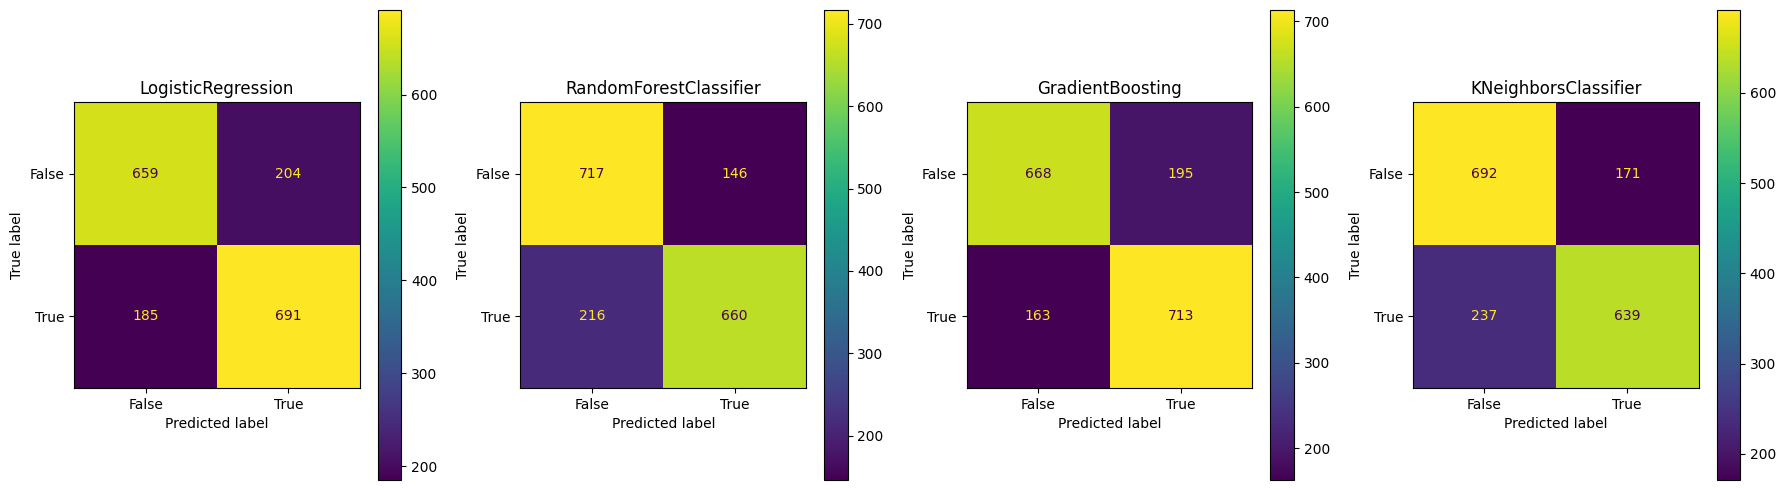

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i in range(4):
  ConfusionMatrixDisplay.from_estimator(models[keys[i]], X_test, y_test, ax=axes[i])
  axes[i].set_title(names[keys[i]])
plt.tight_layout()
plt.show()

Next we can compare ROC curves: it is the plot of the true positive rate against the false positive rate at each threshold setting. Here, all models were more or less the same succesfull.

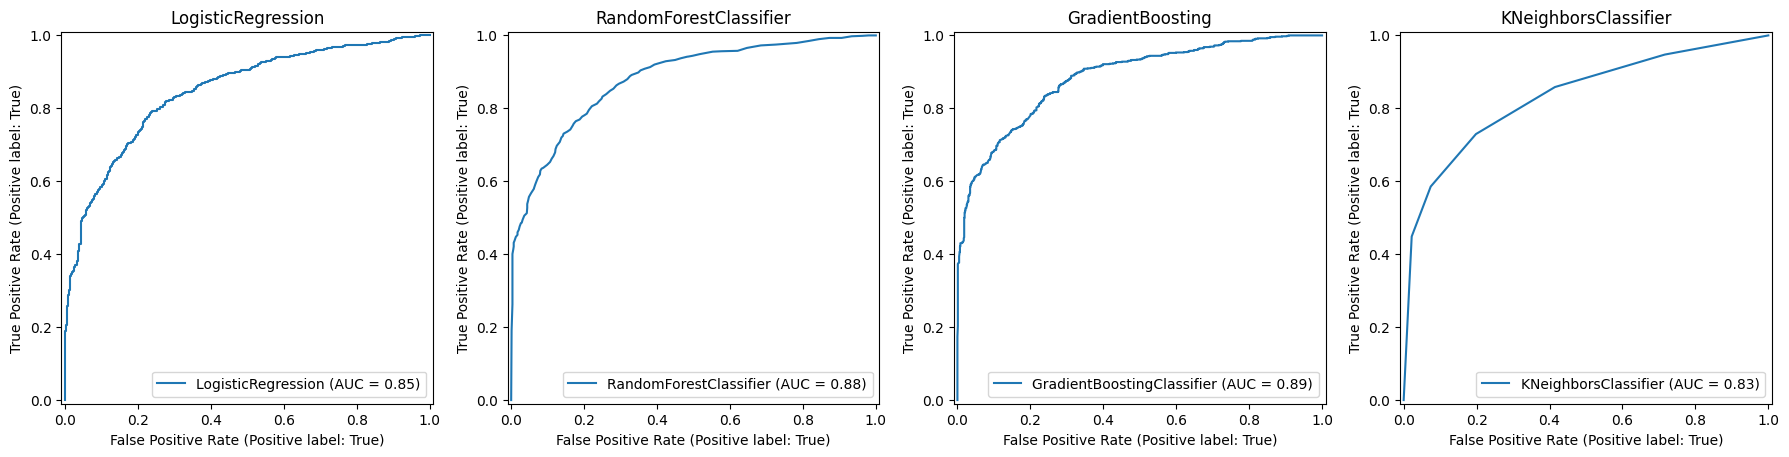

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i in range(4):
  RocCurveDisplay.from_estimator(models[keys[i]], X_test, y_test, ax=axes[i])
  axes[i].set_title(names[keys[i]])
plt.tight_layout()
plt.show()

Next lets compare learning curves of the models. It shows cross-validated training and test scores for different training set sizes. If the training score is much higher than the testing one, it indicates overfitting.

In [39]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

    plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.title(title, fontsize=14)
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

* Logistic Regression

The training and validation curves are close together and flat, suggesting low variance and some underfitting. The model generalizes reasonably well, but likely has limited capacity to capture complex patterns.

* Random Forest

We can clearly see an overfitting here — the model fits training data too well, but doesn't generalize as effectively.

* Gradient Boosting

Shows signs of initial overfitting that improves with more data. The gap between training and validation shrinks slightly — a well-balanced model with room for tuning. Better generalization than Random Forest.

* K-Nearest Neighbors

The model improves as data increases, but still has a consistent gap between training and test scores — suggests moderate variance and possibly too few neighbors.

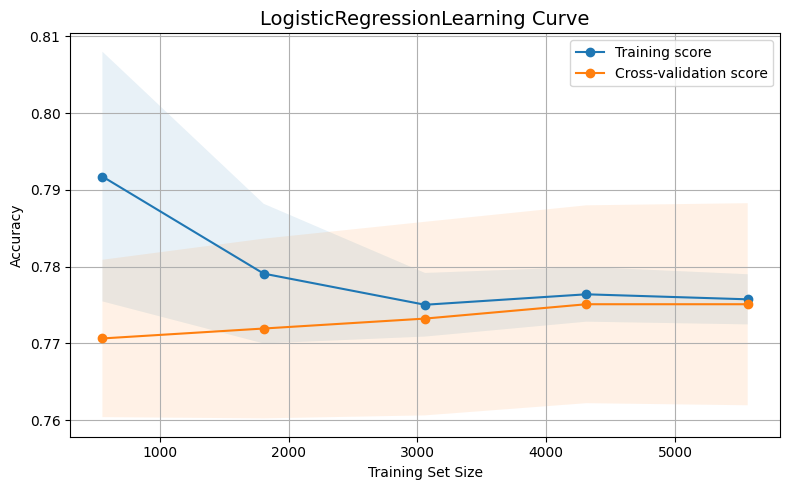

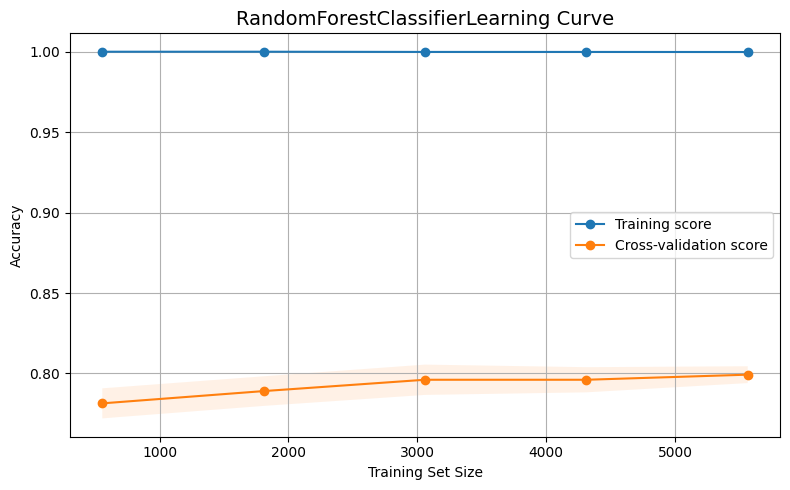

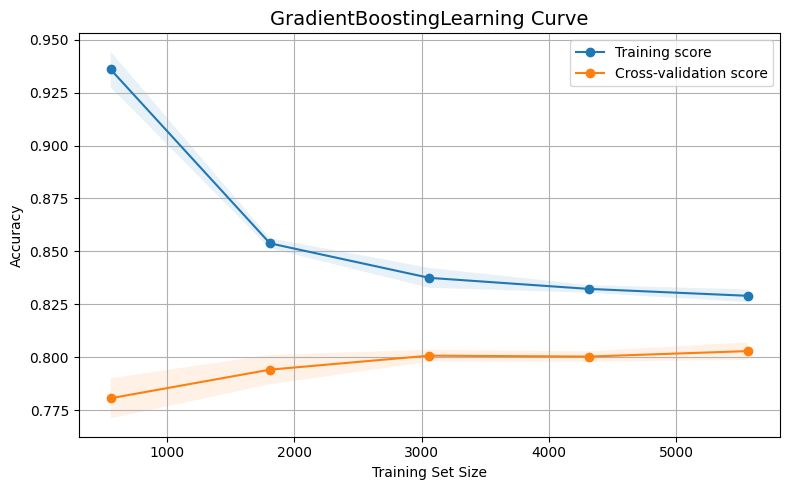

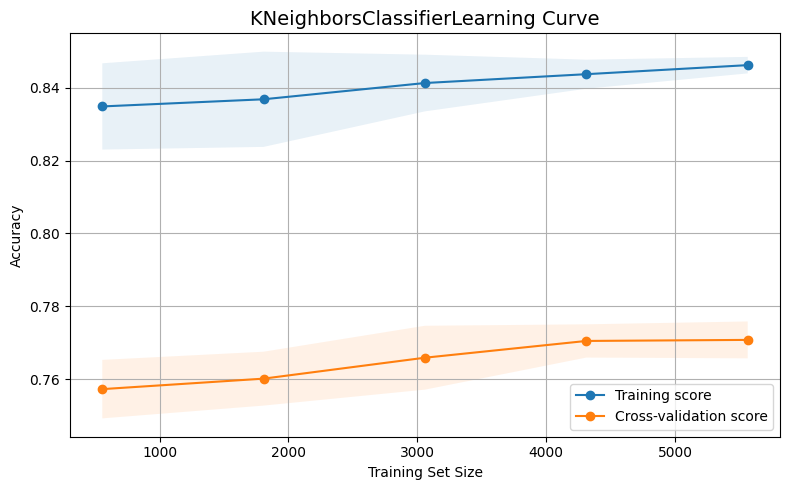

In [40]:
for key in keys: plot_learning_curve(models[key], X_train, y_train, title=names[key] + "Learning Curve")

Another fun parameter to check is the importance of the particular features for tree-based models.

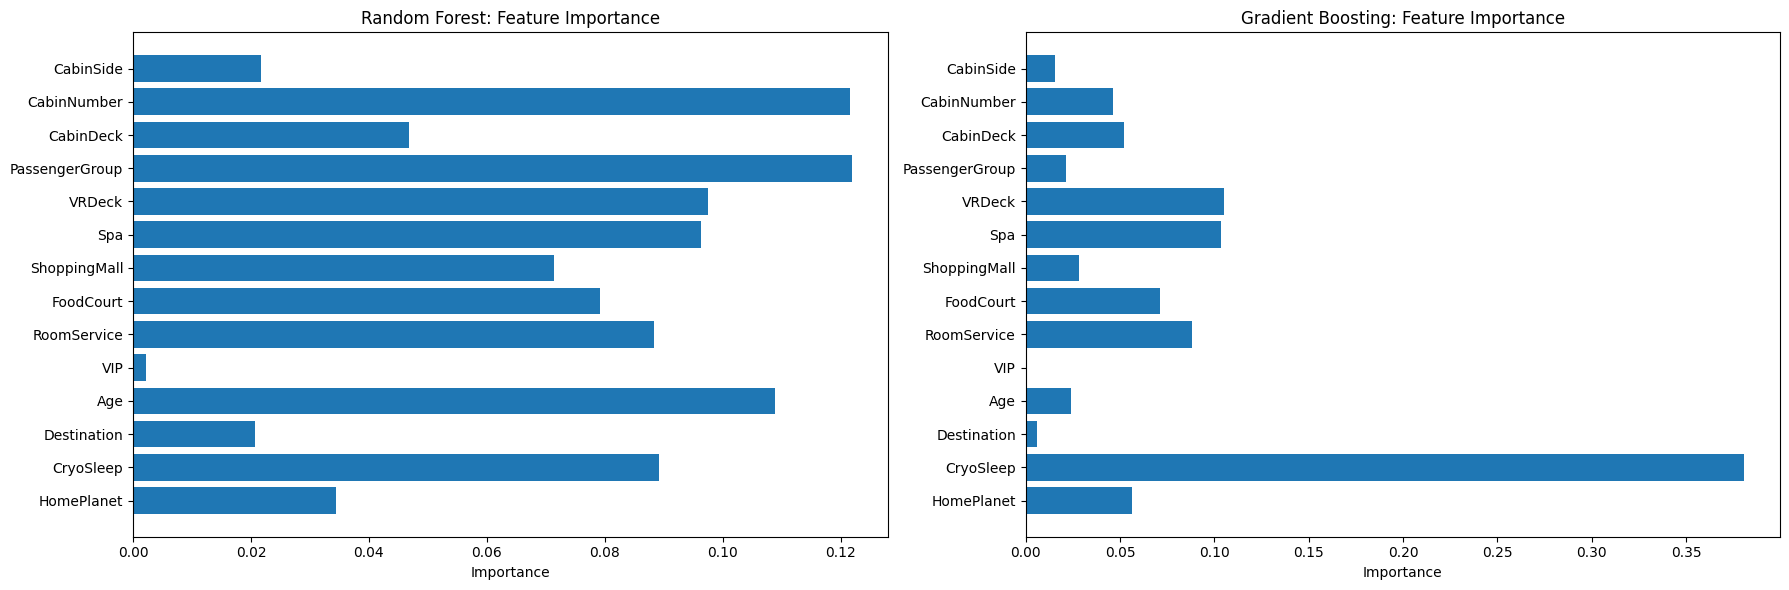

In [41]:
rf_importances = models['rf'].feature_importances_
gb_importances = models['gb'].feature_importances_
features = X_train.columns

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].barh(features, rf_importances)
axes[0].set_title("Random Forest: Feature Importance")
axes[0].set_xlabel("Importance")

axes[1].barh(features, gb_importances)
axes[1].set_title("Gradient Boosting: Feature Importance")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

We can see that Gradient Boosting confirms our initial intuition about `CryoSleep` having high corellation with the label - the model assigned it the most weight. For random forest, the distribution is more equal, dominated features are `CabinNumber`, `PassengerGroup` and `Age`.

# Kaggle submission

As a final result, let's submit our results to Kaggle to see, how well our models performed on an unseen data.

As expected, Gradient Boosting performed the best, achiving 80% accuracy.

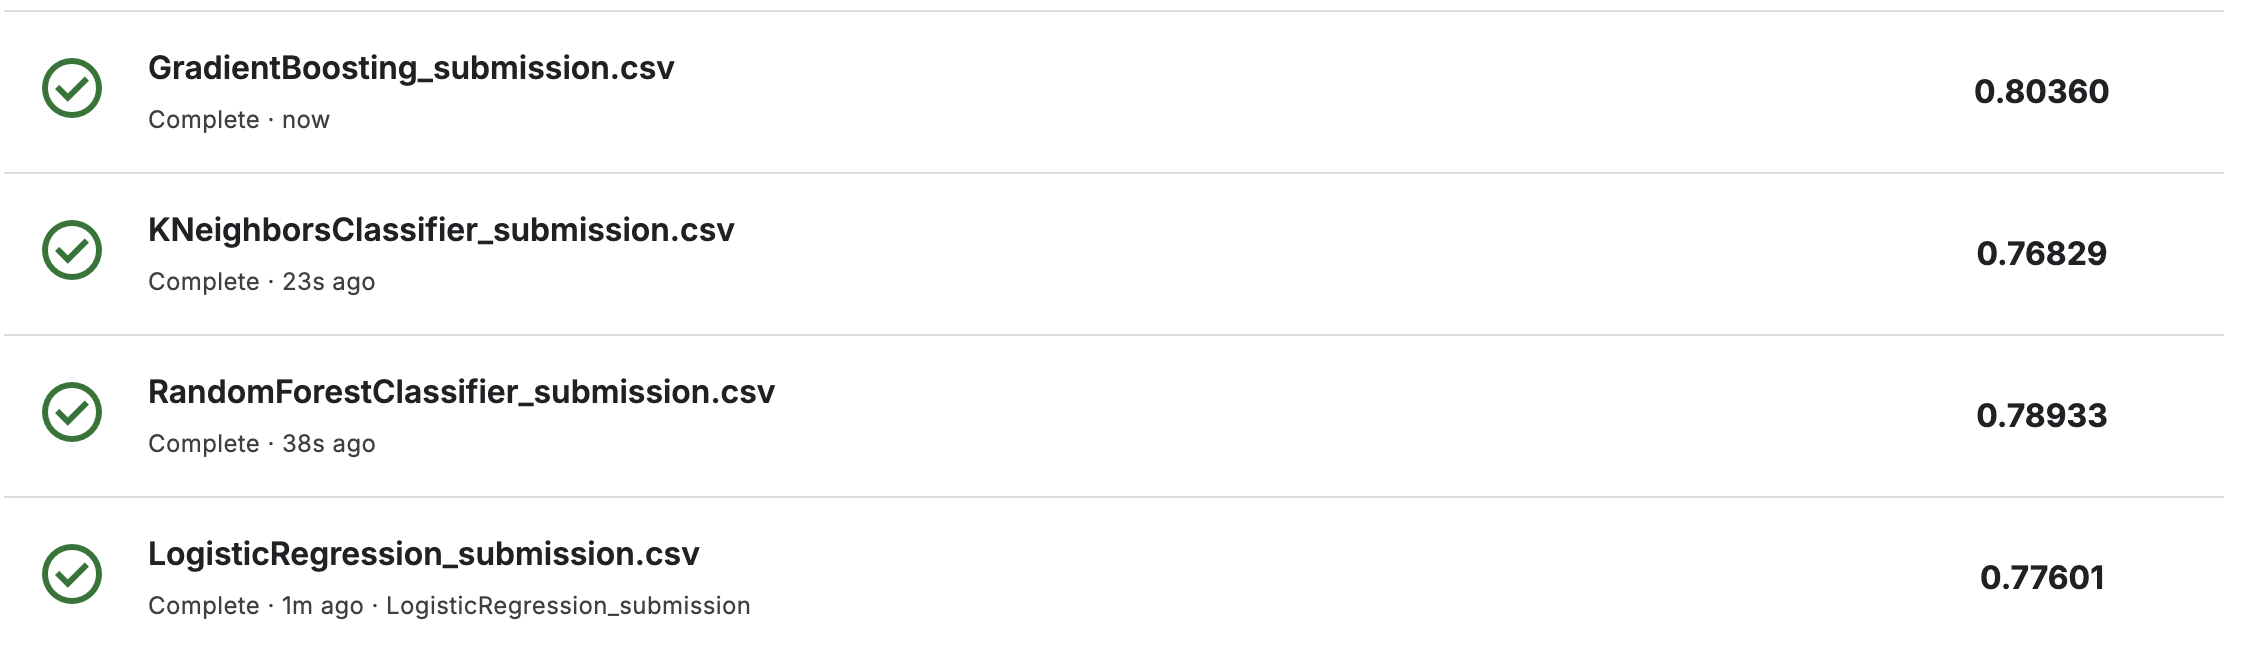